## Part 4: Linear Regression
<a id=part4></a>
$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial {#1}}{\partial {#2}}}
$

In this part we'll perform the classic machine learning task of linear regression.
We'll do some simple data exploration, and implement our solution using some very widely used python libraries 
([`numpy`](https://docs.scipy.org/doc/numpy-1.15.1/reference/),
[`scikit-learn`](http://scikit-learn.org/stable/documentation.html) and
[`pandas`](http://pandas.pydata.org/pandas-docs/stable/))
in order to gain some basic experience with them.
We'll explore the generalization capacity of the model and perform cross validation.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 14})
np.random.seed(42)
test = unittest.TestCase()

###  Dataset exploration
<a id=part4_1></a>

We'll be working with the Boston housing dataset. This is a famous dataset for benchmarking regression algorithms.

The dataset contains 506 samples of median house values in Boston, each with 13 associated house and neighborhood attributes (i.e. features).
(see [here](http://scikit-learn.org/stable/datasets/index.html#boston-dataset) for their meaning).
The 13 features of each house are our independent variables, and  we're trying to predict the value of `MEDV`, the median house price (in units of $1000).

Run the following block to load the data. Since this dataset is very small, we can load it directly into memory and forgo any lazy-loading mechanisms.

In [2]:
import sklearn.datasets

# Load data we'll work with - Boston housing dataset
# We'll use sklearn's built-in data
ds_boston = sklearn.datasets.load_boston()
feature_names = ds_boston.feature_names
n_features = len(feature_names)
x, y = ds_boston.data, ds_boston.target
n_samples = len(y)
print(f'Loaded {n_samples} samples')

# Load into a pandas dataframe and show some samples
df_boston = pd.DataFrame(data=x, columns=ds_boston.feature_names)
df_boston = df_boston.assign(MEDV=y)
df_boston.head(10).style.background_gradient(subset=['MEDV'], high=1.)

Loaded 506 samples


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
5,0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9


Let's explore the data a bit by plotting a scatter matrix of every variable as a function of every other and a histogram for each.

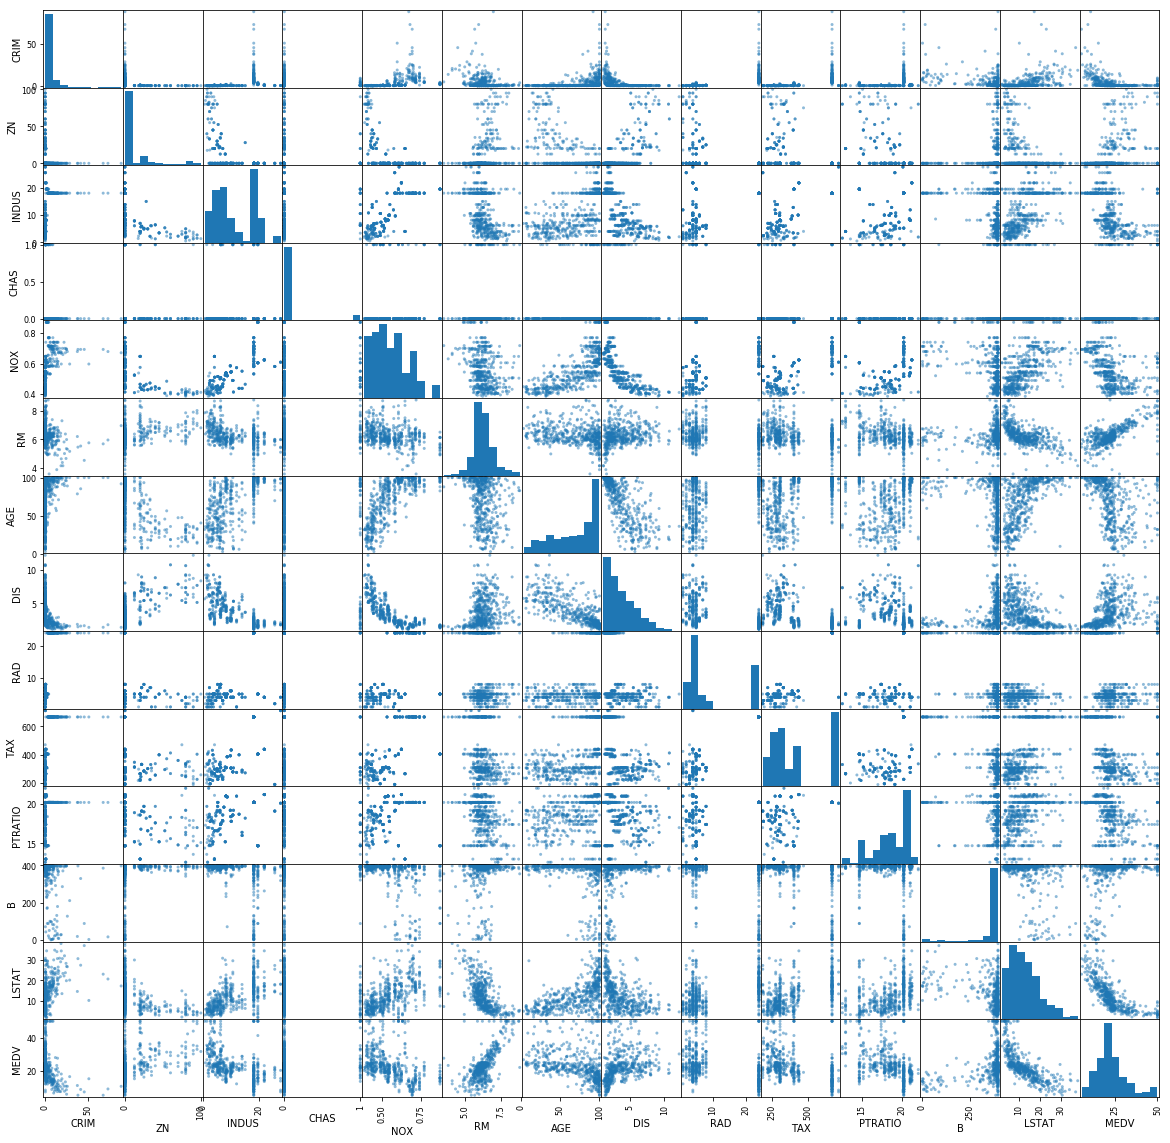

In [3]:
pd.plotting.scatter_matrix(df_boston, figsize=(20,20));

The above chart shows us (among other things) how our target variable `MEDV` behaves as a function
of the features (bottom row). By looking at it, can you guess which relationships might be good candidates for a linear model?

Let's use a simple method for deciding which features to use for our linear model:
the [correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient),
defined as

$$
\rho_{\vec{x}\vec{y}}
= \frac{\sigma_{\vec{x}\vec{y}}}{\sigma_{\vec{x}} \sigma_{\vec{y}}}
= \frac
    {\sum_{i=1}^{N} (x_i - \mu_\vec{x}) (y_i - \mu_\vec{y}) }
    {\sqrt{\sum_{i=1}^{N} (x_i - \mu_\vec{x})^2} \cdot \sqrt{\sum_{i=1}^{N} (y_i - \mu_\vec{y})^2}}
$$

Where $\vec{x}, \vec{y}$ are $N$ samples of two variables and $\mu, \sigma$ refer to **sample** means and (co-)variances respectively.
The value of $\rho$ is $\pm 1$ for perfect positive or negative linear relationships ($y=ax+b$),
and somewhere in between when it's not perfect.
Note that this coefficient is rather limited: even when $\rho=0$, the variables may be highly dependent,
just not in  a linear fashion.

Let's implement this method to find out which features we should include in our initial linear model.

**TODO** Implement the `top_correlated_features()` function in the `hw1/linear_regression.py` module.

In [4]:
import hw1.linear_regression as hw1linreg

n_top_features = 5
top_feature_names, top_corr = hw1linreg.top_correlated_features(df_boston, 'MEDV', n_top_features)
print('Top features: ', top_feature_names)
print('Top features correlations: ', top_corr)

# Tests
test.assertEqual(len(top_feature_names), n_top_features)
test.assertEqual(len(top_corr), n_top_features)
test.assertAlmostEqual(np.sum(np.abs(top_corr)), 2.893, delta=1e-3) # compare to precomputed value for n=5

Top features:  ['LSTAT' 'RM' 'PTRATIO' 'INDUS' 'TAX']
Top features correlations:  LSTAT     -0.737663
RM         0.695360
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
Name: MEDV, dtype: float64


### Linear Regression Model
<a id=part4_2></a>

Arguably the simplest machine learning model is linear regression.
We are given a dataset $\left\{\vec{x}^{(i)}, y^{(i)}\right\}_{i=1}^{N}$ where $\vec{x}^{(i)} \in \set{R}^D$
is a $D$-dimensional feature vector and $y^{(i)}\in\set{R}$ is a continuous quantity assumed to be the
output of some unknown function, i.e. $y^{(i)} = f(\vec{x}^{(i)})$.

Our goal will be to fit a linear transformation,
parametrized by weights vector and bias term $\vec{w}, b$, such that given a sample $\vec{x}$ our prediction is 

$$
\hat{y} = \vectr{w}\vec{x} + b.
$$

We'll judge the performance of the model using the ordinary least-squares sense,
i.e. with a loss function of given by the mean-squared error (MSE) with the addition
of an L2-regularization term:
$$
L(\vec{w})
= \frac{1}{2N} \sum_{i=1}^{N} \left( y^{(i)} - \hat{y}^{(i)} \right)^2 + \frac{\lambda}{2}\norm{\vec{w}}^2_2
= \frac{1}{2N} \sum_{i=1}^{N} \left( y^{(i)} - \vectr{w}\vec{x}^{(i)} - b \right)^2 + \frac{\lambda}{2}\norm{\vec{w}}^2_2.
$$

Minimizing the above $L(\vec{w})$ is a simple convex optimization problem
with a closed-form solution. Of course, this can also be solved using iterative descent methods which
are necessary when the data is too large to fit in memory.

As a warm up, let's implement the bias trick (this time as a `sklearn` transformation)
so that our linear regression model will operate on data with an added bias term.

**TODO** Implement the class `BiasTrickTransformer` in the `hw1/linear_regression.py` module.

In [5]:
# Test BiasTrickTransformer
bias_tf = hw1linreg.BiasTrickTransformer()

xt1 = np.random.randint(10, 20, size=(5,2))
xt2 = np.random.randn(10, 1)
for xt in (xt2, xt1):
    xb = bias_tf.fit_transform(xt)
    test.assertEqual(xb.ndim, 2)
    test.assertTrue(np.all(xb[:,0] == 1))
    test.assertTrue(np.all(xb[:, 1:] == xt))
    
print(xb)

[[ 1. 16. 13.]
 [ 1. 17. 14.]
 [ 1. 16. 19.]
 [ 1. 12. 16.]
 [ 1. 17. 14.]]


Lets now define a function to assess the accuracy of our models prediction (loss and score).
We'll use the MSE loss as above and [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) as a score.

In [6]:
def evaluate_accuracy(y: np.ndarray, y_pred: np.ndarray):
    """
    Calculates mean squared error (MSE) and coefficient of determination (R-squared).
    :param y: Target values.
    :param y_pred: Predicted values.
    :return: A tuple containing the MSE and R-squared values.
    """
    mse = np.mean((y - y_pred) ** 2)
    rsq = 1 - mse / np.var(y)
    return mse.item(), rsq.item()

Now we can implement our model.

**TODO** Based on the above equations, implement the `predict()` and `fit()`
functions in the `LinearRegressor` class within the module `linear_regression.py`.
You'll need to first derive the closed-form solution for the optimal $\vec{w}$ based on the loss.
Run the code block below to fit your model to each of the 5 top
features you selected (one at a time).

AssertionError: 44.762 != 43.601991599612795 within 0.1 delta (1.1600084003872055 difference)

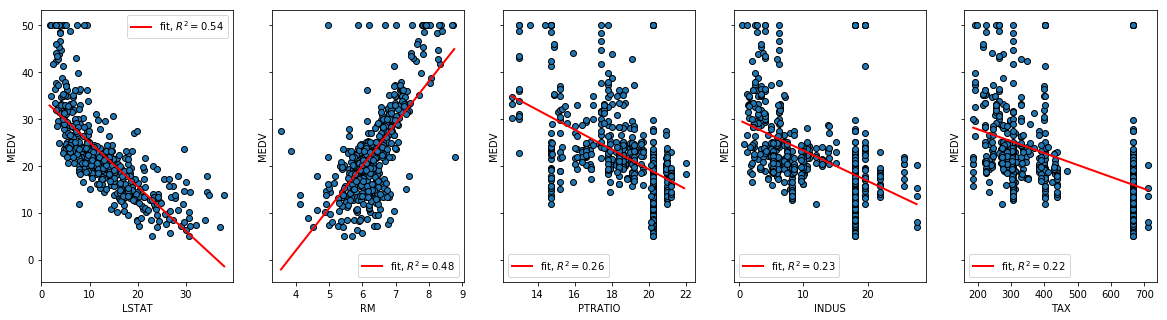

In [16]:
### import sklearn.pipeline

fig, ax = plt.subplots(nrows=1, ncols=n_top_features, sharey=True, figsize=(20,5))
actual_mse = []

# Create our model as a pipline: First the bias trick is applied, then the regressor
model = sklearn.pipeline.make_pipeline(
    hw1linreg.BiasTrickTransformer(),
    hw1linreg.LinearRegressor(),
)

# Fit a single feature at a time
for i, feature_name in enumerate(top_feature_names):
    xf = df_boston[feature_name].values.reshape(-1, 1)

    y_pred = model.fit_predict(xf, y)
    mse, rsq = evaluate_accuracy(y, y_pred)

    x_line = np.arange(xf.min(), xf.max(), 0.1, dtype=np.float).reshape(-1, 1)
    y_line = model.predict(x_line)

    # Plot
    ax[i].scatter(xf, y, marker='o', edgecolor='black')
    ax[i].plot(x_line, y_line, color='red', lw=2, label=f'fit, $R^2={rsq:.2f}$')
    ax[i].set_ylabel('MEDV')
    ax[i].set_xlabel(feature_name)
    ax[i].legend()
    
    actual_mse.append(mse)

# Test regressor implementation
expected_mse = [38.483, 44.762, 62.661, 64.666, 65.887]
for i in range(len(expected_mse)):
    test.assertAlmostEqual(expected_mse[i], actual_mse[i], delta=1e-1)

As you can see, the results are not great. We can't reliably predict the target variable based on just one of these.
Now let's fit a model based on the combined top-5 features.
Since it's difficult to visualize high-dimensional hyperplanes,
instead of plotting the data and fitted hyperplane, we'll create a **residuals** plot. This is the plot of the error, or residual $e^{(i)} = y^{(i)} - \hat{y}^{(i)}$ vs. the predicted value $\hat{y}^{(i)}$.

mse5=26.98, rsq5=0.68


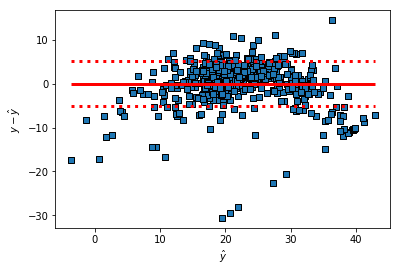

In [17]:
# Fit top-5 features
xf_top = df_boston[top_feature_names].values

y_pred = model.fit_predict(xf_top, y)
mse5, rsq5 = evaluate_accuracy(y, y_pred)
print(f'mse5={mse5:.2f}, rsq5={rsq5:.2f}')

# Residuals plot
def plot_residuals(y, y_pred, ax=None, res_label=None):
    if ax is None:
        _, ax = plt.subplots()
    res = y - y_pred
    ax.scatter(y_pred, y_pred-y, marker='s', edgecolor='black', label=res_label)
    ax.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', lw=3)
    ax.hlines(y=[-res.std(), res.std()], xmin=y_pred.min(), xmax=y_pred.max(), color='red', lw=3, linestyles=':')
    ax.set_xlabel(r'$\hat{y}$')
    ax.set_ylabel(r'$y - \hat{y}$')
    if res_label is not None:
        ax.legend()
    return ax

plot_residuals(y, y_pred)

test.assertLess(mse5, 30)

That's better, but there's still more to be desired. Let's try to improve our model further.

### Adding nonlinear features
<a id=part4_3></a>

We can see that many of the relationships between our features and target variable are obviously not linear and
cannot be modeled completely by fitting lines (or hyperplanes).
Is there a way to fit a non-linear function to the data (such as a polynomial) but still use the simplicity of the
Linear Regression model?

A Linear Regression model actually only needs to be linear in the **parameters** of the model.
It doesn't care what possibly nonlinear relationships exists between the feature values. This means that
we can increase the **capacity** of our model (its ability to fit a wide variety of functions) by adding
more parameters that correspond to non-linear transformations of the features. 

Suppose we have 2-dimensional feature vectors, $\vec{x}=(x_1, x_2)$.
We can fit a linear regression model with 3 parameters which represent some 2-d plane.
However if we transform each such feature vector, for example by
$\vec{\tilde{x}} = (x_1, x_2, x_1^2, x_1 x_2, x_2^2)$ then we can now fit a model with 6 parameters to
the same data. These parameters still represent a hyperplane, but in a higher dimensional space which
combines the original features. Thus, when looking at the prediction surface in the original 2-d space,
we'll see that the model actually fitted a non-linear surface instead of a 2-d plane - in this example
a second order polynomial. The model is still linear, since the prediction method is now 
$\hat{y} = \vectr{w}\vec{\tilde{x}} + b$, but it's capacity has been increased.

Let's implement some hand-crafted nonlinear features based on all the features in the dataset.
This step in the machine learning process is sometimes also referred to as feature engineering.
In the rest of the course, you'll see how Deep Learning
allows us to learn the features themselves instead of creating them by hand, and thus creating very
powerful representations.

**TODO** Implement the `BostonFeaturesTransformer` class in the `hw1/linear_regression.py` module.
You can create any features you want, for example given $\vec{x}=(x_1,x_2)$ you could generate features
such as $x_1^2$, $x_1 \log{x_2}$,  $e^{-x_1}$ and so on.
Try to infer relationships based on the scatter matrix.

Notes:
- You can use the class `PolynomialFeatures` from `sklearn.preprocessing`
  to simplify generation of polynomial features.
- Removing a feature is also a new feature. You can discard features if they're not helpful.

mse=6.22, rsq=0.93


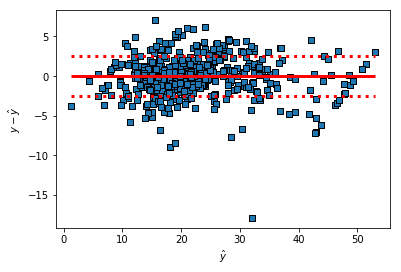

In [20]:
def linreg_boston(model, x, y, fit=True):
    if fit:
        model.fit(x, y)
    y_pred = model.predict(x)
    mse, rsq = evaluate_accuracy(y, y_pred)
    return y_pred, mse, rsq

# Fit with all features this time
x = df_boston[feature_names].values

# Use model with a custom features transform
model = sklearn.pipeline.make_pipeline(
    hw1linreg.BiasTrickTransformer(),
    hw1linreg.BostonFeaturesTransformer(),
    hw1linreg.LinearRegressor()
)

y_pred, mse, rsq = linreg_boston(model, x, y)
print(f'mse={mse:.2f}, rsq={rsq:.2f}')

# Test: You should get at least 2x lower loss than previously, easily even lower
plot_residuals(y, y_pred)
test.assertLess(mse, mse5 / 2)

### Generalization
<a id=part4_4></a>

By now, your model should produce fairly accurate predictions.
Note howerver that we trained it on the entire Boston dataset.

When training models, we don't actually care about their performance on the training data;
we're not interested in solving optimization problems.
What we want is the ability to **generalize**: How well will it perform on novel, unseen data?
In other words, did the model learn some function similar to the one actually generating the samples?

Let's find out how good our model is for unseen data the usual way: We'll split our dataset into a training and test set.

In [21]:
from sklearn.model_selection import train_test_split

# Data and model
x = df_boston[feature_names].values
y = df_boston['MEDV'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = sklearn.pipeline.make_pipeline(
    hw1linreg.BiasTrickTransformer(),
    hw1linreg.BostonFeaturesTransformer(),
    hw1linreg.LinearRegressor()
)

However, instead of just fitting the model on the training set and evaluating on the test set,
we'll use cross-validation to find a set of model hyperparameters that allow the model to generalize well.
We'll again use k-fold CV to split the training set into k-folds where for each set of hyperparameters being tested,
each time one of the folds is treated like the test set and the model is fitted to the rest.

**TODO** Implement the `cv_best_hyperparams()` function in the `hw1/linear_regression.py` module.

In [ ]:
# Define search-spaces for hyper parameters
degree_range = np.arange(1, 4)
lambda_range = np.logspace(-3, 2, base=10, num=20)

# Use cross-validation to find best combination of hyperparameters
best_hypers = hw1linreg.cv_best_hyperparams(model, x_train, y_train, k_folds=3,
                                            degree_range=degree_range, lambda_range=lambda_range)

print('Best hyperparameters: ', best_hypers)

# Make sure returned params exist in the model
for param in best_hypers.keys():
    test.assertIn(param, model.get_params())

Now lets use the best hyperparameters to train a model on the training set and evaluate it on the test set.

In [ ]:
# Use the best hyperparameters
model.set_params(**best_hypers)

# Train best model on full training set
y_pred_train, mse, rsq = linreg_boston(model, x_train, y_train)
print(f'train: mse={mse:.2f}, rsq={rsq:.2f}')
ax = plot_residuals(y_train, y_pred_train, res_label='train')

# Evaluate on test set
y_pred_test, mse, rsq = linreg_boston(model, x_test, y_test, fit=False)
print(f'test:  mse={mse:.2f}, rsq={rsq:.2f}')
ax = plot_residuals(y_test, y_pred_test, ax=ax, res_label='test')

# Make sure test-set accuracy is sane
test.assertLess(mse, 25) # You should be able to get way below this

### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw1/answers.py`.


In [ ]:
from cs236605.answers import display_answer
import hw1.answers

#### Question 1 

Whats the ideal pattern to see in a residual plot?
Based on the residual plots you got above, what can you say about the fitness of the trained model?
Compare the plot for the top-5 features with the final plot after CV.


In [ ]:
display_answer(hw1.answers.part4_q1)

#### Question 2

Regarding the cross-validation:

1. When defining the range for $\lambda$ the in the above CV code, why do you think we used
   `np.logspace` instead of `np.linspace`?
1. How many times in total was the model fitted to data (with the parameters as given and not including the final fit on the entire training set)?


In [ ]:
display_answer(hw1.answers.part4_q2)